In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    case_name = "M_264_5k"
    npy_file_name_aniso = f"p_ori_fully5d_fzab_aveE_f1.0_t0.0_264_5k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_aniso_energy = f"p_ori_fully5d_fzab_aveE_f1.0_t0.0_264_5k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} energy data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The M_264_5k data size is: (51, 264, 264, 264)
READING DATA DONE
The M_264_5k energy data size is: (51, 264, 264, 264)
READING ENERGY DATA DONE


In [3]:
    # YOU should remove the very small GB due to the less impact on curvature study
    # YOU should use different accuracy algorithm on voxels around the TJs.
    # A potential error: some small spherical GB are generated around large GB with same GB id
    
    
    step_num=51
    grain_nums = 5000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name,allow_pickle=True)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix.item())
            else:
                # cores = 128
                # loop_times = 5
                # R = np.zeros((size_x,size_y,size_z,4))
                # smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,current_microstructure,R,'p',verification_system = False,curvature_sign = True)
                # smoothing_class.linear3d_main("curvature")
                # C_ln = smoothing_class.get_C()
                # curvature_matrix = C_ln[1,:]
                # curvature_matrix_list.append(curvature_matrix)
                curvature_matrix = post_processing.IO_curvature(current_microstructure)
                # save curvature information
                np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # # Get TJ and QJ information first
            # TJ_infomation_dict = dict()
            # for index, result in np.ndenumerate(current_microstructure):
            #     i,j,k = index
            #     ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
            #     if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            #         central_site = int(current_microstructure[i,j,k])
            #         neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            #         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            #         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            #         neighboring_sites_list_unque = list(neighboring_sites_set)
            #         # remove the TJs and QJs
            #         if len(neighboring_sites_list_unque) > 1: 
            #             for m in range(len(neighboring_sites_list_unque)):
            #                 pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
            #                 if pair_id in TJ_infomation_dict:
            #                     tmp = TJ_infomation_dict[pair_id]
            #                     tmp.append([i,j,k])
            #                     TJ_infomation_dict[pair_id] = tmp
            #                 else: 
            #                     TJ_infomation_dict[pair_id] = [[i,j,k]]
            # print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 1 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                        GB_infomation_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    # # CONTINUE...    # remove the voxels around TJs and QJs
                    # # check the GB voxels is close to TJ or not
                    # break_point = 0
                    # if pair_id in TJ_infomation_dict:
                    #     for TJ_site in TJ_infomation_dict[pair_id]:
                    #         TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                    #         if TJ_distance < TJ_distance_max: 
                    #             break_point = 1
                    #             break
                    # if break_point == 1: continue
                    
                    # calculate or extract curvature
                    if pair_id not in curvature_matrix: continue
                    GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[pair_id][3]])
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)
            
            
            

100%|██████████| 51/51 [00:00<00:00, 134.72it/s]


In [4]:
    # GB Energy information
    step_num=51
    grain_nums = 5000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/3D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # # Get TJ and QJ information first
            # TJ_infomation_dict = dict()
            # for index, result in np.ndenumerate(current_microstructure):
            #     i,j,k = index
            #     ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
            #     if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            #         central_site = int(current_microstructure[i,j,k])
            #         neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            #         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            #         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            #         neighboring_sites_list_unque = list(neighboring_sites_set)
            #         # remove the TJs and QJs
            #         if len(neighboring_sites_list_unque) > 1: 
            #             for m in range(len(neighboring_sites_list_unque)):
            #                 pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
            #                 if pair_id in TJ_infomation_dict:
            #                     tmp = TJ_infomation_dict[pair_id]
            #                     tmp.append([i,j,k])
            #                     TJ_infomation_dict[pair_id] = tmp
            #                 else: 
            #                     TJ_infomation_dict[pair_id] = [[i,j,k]]
            # print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 1 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k],
                                                            current_microstructure[i,j,km], current_microstructure[ip,jp,km], current_microstructure[ip,j,km], current_microstructure[ip,jm,km], current_microstructure[i,jp,km], current_microstructure[i,jm,km], current_microstructure[im,jp,km], current_microstructure[im,j,km], current_microstructure[im,jm,km],
                                                            current_microstructure[i,j,kp], current_microstructure[ip,jp,kp], current_microstructure[ip,j,kp], current_microstructure[ip,jm,kp], current_microstructure[i,jp,kp], current_microstructure[i,jm,kp], current_microstructure[im,jp,kp], current_microstructure[im,j,kp], current_microstructure[im,jm,kp]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                        GBenergy_information_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    # remove the TJs and QJs
                    # if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # # CONTINUE...    # remove the voxels around TJs and QJs
                    # # check the GB voxels is close to TJ or not
                    # break_point = 0
                    # if pair_id in TJ_infomation_dict:
                    #     for TJ_site in TJ_infomation_dict[pair_id]:
                    #         TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                    #         if TJ_distance < TJ_distance_max: 
                    #             break_point = 1
                    #             break
                    # if break_point == 1: continue
                    # calculate or extract GB energy
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 51/51 [00:00<00:00, 139.37it/s]


In [5]:
    time_interval = 2
    curvature_limit = 0.00794
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    # store all GB point exclude anti-curvature randomness points
    GB_list_velocity_list_exrandom = []
    GB_list_curvature_list_exrandom = []
    # store GB energy point exclude anti_c randomness points
    GB_list_GBenergy_list_exrandom = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_velocity_list_exrandom_tmp = []
        GB_list_curvature_list_exrandom_tmp = []
        GB_list_GBenergy_list_exrandom_tmp = []
        key_set = set()
        for key in tqdm(GB_infomation_dict_list[time_step]):
            if GB_infomation_dict_list[time_step+1].get(key) is None: continue
            if GB_infomation_dict_list[time_step][key][5] < 100: continue # remove small GBs
            if abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
            GB_list_velocity_list_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step][key][4]
            GB_list_curvature_list_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_tmp.append(GBenergy_information_dict_list[time_step][key][4])
            
            # keep anti-curvature GB info
            if current_curvature_value*velocity<-0.0001: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        
        # keep all GBs with GB length larger than 100
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        
        # filter the anti-curvature GB with 00100
        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")
        
        # remove exclude data
        if time_step < 2: continue
        for key in tqdm(GB_infomation_dict_list[time_step-2]):
            if GB_infomation_dict_list[time_step-1].get(key) is None: continue
            if GB_infomation_dict_list[time_step-2][key][5] < 100: continue # remove small GBs
            if key in filtered_set: continue # remove the randomness points
            if abs(GB_infomation_dict_list[time_step-2][key][4]) < curvature_limit: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step-2][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step-2]==pair_id_pair[0])*(npy_file_aniso[time_step-1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step-2]==pair_id_pair[1])*(npy_file_aniso[time_step-1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step-2][key][5]/2)
            GB_list_velocity_list_exrandom_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step-2][key][4]
            GB_list_curvature_list_exrandom_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_exrandom_tmp.append(GBenergy_information_dict_list[time_step-2][key][4])
        GB_list_velocity_list_exrandom.append(GB_list_velocity_list_exrandom_tmp)
        GB_list_curvature_list_exrandom.append(GB_list_curvature_list_exrandom_tmp)
        GB_list_GBenergy_list_exrandom.append(GB_list_GBenergy_list_exrandom_tmp)
        
    
    # filter the anti-curvature GB with 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)
            
    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])
            

100%|██████████| 4058/4058 [00:15<00:00, 264.97it/s]


finish 0 with num of GBs 198, and collected num of GBs 96


100%|██████████| 2235/2235 [01:26<00:00, 25.85it/s]


finish 1 with num of GBs 1121, and collected num of GBs 404


100%|██████████| 2638/2638 [01:52<00:00, 23.50it/s]


finish 2 with num of GBs 1463, and collected num of GBs 779


100%|██████████| 3084/3084 [02:12<00:00, 23.32it/s]


finish 3 with num of GBs 1727, and collected num of GBs 1142


100%|██████████| 3553/3553 [02:31<00:00, 23.48it/s]


finish 4 with num of GBs 1944, and collected num of GBs 1554


100%|██████████| 3770/3770 [02:33<00:00, 24.60it/s]


finish 5 with num of GBs 2006, and collected num of GBs 1897


100%|██████████| 3836/3836 [02:32<00:00, 25.11it/s]


finish 6 with num of GBs 2012, and collected num of GBs 2239


100%|██████████| 3813/3813 [02:34<00:00, 24.67it/s]


finish 7 with num of GBs 2001, and collected num of GBs 2502


100%|██████████| 3775/3775 [02:32<00:00, 24.76it/s]


finish 8 with num of GBs 1993, and collected num of GBs 2740


100%|██████████| 3720/3720 [02:24<00:00, 25.80it/s]


finish 9 with num of GBs 1884, and collected num of GBs 2940


100%|██████████| 3585/3585 [02:19<00:00, 25.66it/s]


finish 10 with num of GBs 1835, and collected num of GBs 3137


100%|██████████| 3429/3429 [02:09<00:00, 26.41it/s]


finish 11 with num of GBs 1693, and collected num of GBs 3299


100%|██████████| 3260/3260 [02:07<00:00, 25.62it/s]


finish 12 with num of GBs 1669, and collected num of GBs 3464


100%|██████████| 3158/3158 [01:59<00:00, 26.36it/s]


finish 13 with num of GBs 1571, and collected num of GBs 3609


100%|██████████| 3024/3024 [01:52<00:00, 26.91it/s]


finish 14 with num of GBs 1473, and collected num of GBs 3731


100%|██████████| 2861/2861 [01:44<00:00, 27.43it/s]


finish 15 with num of GBs 1371, and collected num of GBs 3832


100%|██████████| 2703/2703 [01:36<00:00, 27.98it/s]


finish 16 with num of GBs 1270, and collected num of GBs 3925


100%|██████████| 2570/2570 [01:34<00:00, 27.23it/s]


finish 17 with num of GBs 1244, and collected num of GBs 4000


100%|██████████| 2456/2456 [01:28<00:00, 27.84it/s]


finish 18 with num of GBs 1160, and collected num of GBs 4072


100%|██████████| 2343/2343 [01:26<00:00, 27.02it/s]


finish 19 with num of GBs 1134, and collected num of GBs 4137


100%|██████████| 2258/2258 [01:22<00:00, 27.23it/s]


finish 20 with num of GBs 1084, and collected num of GBs 4207


100%|██████████| 2140/2140 [01:15<00:00, 28.21it/s]


finish 21 with num of GBs 989, and collected num of GBs 4254


100%|██████████| 2047/2047 [01:12<00:00, 28.36it/s]


finish 22 with num of GBs 955, and collected num of GBs 4298


100%|██████████| 1937/1937 [01:08<00:00, 28.46it/s]


finish 23 with num of GBs 899, and collected num of GBs 4347


100%|██████████| 1858/1858 [01:02<00:00, 29.50it/s]


finish 24 with num of GBs 830, and collected num of GBs 4380


100%|██████████| 1770/1770 [01:01<00:00, 28.78it/s]


finish 25 with num of GBs 811, and collected num of GBs 4416


100%|██████████| 1681/1681 [00:56<00:00, 29.88it/s]


finish 26 with num of GBs 744, and collected num of GBs 4450


100%|██████████| 1578/1578 [00:51<00:00, 30.37it/s]


finish 27 with num of GBs 686, and collected num of GBs 4479


100%|██████████| 1491/1491 [00:48<00:00, 30.64it/s]


finish 28 with num of GBs 641, and collected num of GBs 4508


100%|██████████| 1443/1443 [00:45<00:00, 31.83it/s]


finish 29 with num of GBs 597, and collected num of GBs 4534


100%|██████████| 1374/1374 [00:39<00:00, 34.72it/s]


finish 30 with num of GBs 521, and collected num of GBs 4546


100%|██████████| 1292/1292 [00:38<00:00, 33.61it/s]


finish 31 with num of GBs 508, and collected num of GBs 4571


100%|██████████| 1252/1252 [00:36<00:00, 33.86it/s]


finish 32 with num of GBs 486, and collected num of GBs 4599


100%|██████████| 1198/1198 [00:34<00:00, 35.14it/s]


finish 33 with num of GBs 448, and collected num of GBs 4614


100%|██████████| 1162/1162 [00:33<00:00, 34.84it/s]


finish 34 with num of GBs 439, and collected num of GBs 4630


100%|██████████| 1115/1115 [00:33<00:00, 33.51it/s]


finish 35 with num of GBs 438, and collected num of GBs 4655


100%|██████████| 1093/1093 [00:30<00:00, 35.58it/s]


finish 36 with num of GBs 404, and collected num of GBs 4668


100%|██████████| 1050/1050 [00:29<00:00, 35.49it/s]


finish 37 with num of GBs 389, and collected num of GBs 4687


100%|██████████| 1014/1014 [00:27<00:00, 36.97it/s]


finish 38 with num of GBs 359, and collected num of GBs 4703


100%|██████████| 988/988 [00:26<00:00, 37.67it/s]


finish 39 with num of GBs 345, and collected num of GBs 4720


100%|██████████| 948/948 [00:24<00:00, 38.29it/s]


finish 40 with num of GBs 325, and collected num of GBs 4729


100%|██████████| 934/934 [00:24<00:00, 38.83it/s]


finish 41 with num of GBs 316, and collected num of GBs 4743


100%|██████████| 905/905 [00:22<00:00, 39.83it/s]


finish 42 with num of GBs 299, and collected num of GBs 4749


100%|██████████| 886/886 [00:22<00:00, 39.52it/s]


finish 43 with num of GBs 295, and collected num of GBs 4754


100%|██████████| 874/874 [00:22<00:00, 39.08it/s]


finish 44 with num of GBs 296, and collected num of GBs 4761


100%|██████████| 844/844 [00:20<00:00, 40.35it/s]


finish 45 with num of GBs 276, and collected num of GBs 4774


100%|██████████| 806/806 [00:21<00:00, 37.37it/s]


finish 46 with num of GBs 284, and collected num of GBs 4782


100%|██████████| 787/787 [00:20<00:00, 39.04it/s]


finish 47 with num of GBs 265, and collected num of GBs 4794


100%|██████████| 775/775 [00:18<00:00, 42.36it/s]


finish 48 with num of GBs 242, and collected num of GBs 4794


100%|██████████| 756/756 [00:19<00:00, 39.29it/s]


finish 49 with num of GBs 251, and collected num of GBs 4794


100%|██████████| 787/787 [00:19<00:00, 41.34it/s]


In [6]:
len(GB_id_focus_copy)

4794

In [7]:
    time_interval = 2
    # GB_list_velocity_list = []
    GB_antic_list_velocity_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_id_unfocus_lowE_detail = dict()
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        for key in tqdm(GBenergy_information_dict_list[time_step]):
            if GBenergy_information_dict_list[time_step+1].get(key) is None: continue
            if GBenergy_information_dict_list[time_step][key][5] < 100: continue # remove small GBs
            if abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit: continue # remove low curvature
            
            # keep the GB with low energy and curvature behavior
            if (GBenergy_information_dict_list[time_step][key][4]<0.4) and (key not in GB_id_focus_detail): # do we need to remove random here?
                if key in GB_id_unfocus_lowE_detail:
                    GB_id_unfocus_lowE_detail[key].append(time_step)
                else:
                    GB_id_unfocus_lowE_detail[key] = [time_step]
            
            # anti-curvature behavior list
            if (key in GB_id_focus_detail) and (time_step in GB_id_focus_detail[key]):
                # Calculate dV
                pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
                growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
                growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
                dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
                # calculate velocity
                velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
                # correct the sign of velocity
                current_curvature_value = GB_infomation_dict_list[time_step][key][4]
                if current_curvature_value < 0: GB_antic_list_velocity_list.append(-velocity)
                else: GB_antic_list_velocity_list.append(velocity)
                
                GB_antic_list_GBenergy_list.append(GBenergy_information_dict_list[time_step][key][4])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
            
        
            

100%|██████████| 756/756 [00:00<00:00, 920968.29it/s]


In [8]:
    total_GB = set()
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB = total_GB | step_GB

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_id_focus.values())}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_id_focus.values())/len(total_GB)*100}% in {len(total_GB)} GBs")
    print(GB_id_focus.values())

The number of the GBs showing anti-curvature during whole simulations is 1354
The ratio of anti-curvature GBs during whole simulations is 10.399385560675883% in 13020 GBs
dict_values([2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 4, 2, 2, 2, 2, 3, 4, 3, 2, 2, 2, 5, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 4, 2, 3, 2, 2, 2, 4, 2, 2, 2, 3, 6, 2, 2, 2, 2, 3, 2, 2, 4, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 4, 3, 2, 2, 2, 3, 2, 2, 2, 4, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 5, 2, 2, 3, 2, 3, 3, 2, 5, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 5, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 4, 2, 5, 3, 4, 2, 2, 2, 3, 3, 2, 2, 3, 2, 6, 4, 2, 3, 4, 3, 3, 

In [9]:
len(GB_list_velocity_list)

50

<Figure size 432x288 with 0 Axes>

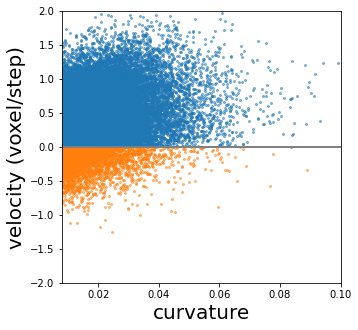

<Figure size 432x288 with 0 Axes>

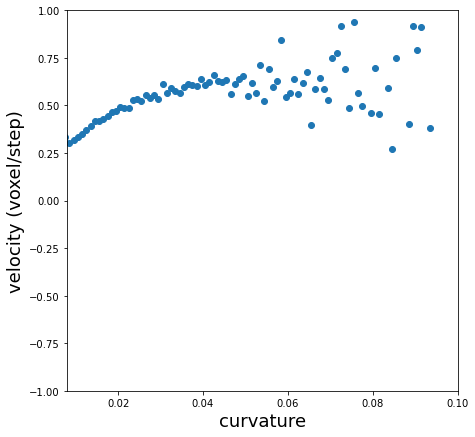

In [10]:
    # All in 1 figrue
    curvature_1Dlist_remove_0step = []
    velocity_1Dlist_remove_0step = []
    GBenergy_1Dlist_remove_0step = []
    for i in range(0,len(GB_list_velocity_list)): 
        curvature_1Dlist_remove_0step.extend(GB_list_curvature_list[i])
        velocity_1Dlist_remove_0step.extend(GB_list_velocity_list[i])
        GBenergy_1Dlist_remove_0step.extend(GB_list_GBenergy_list[i])
    curvature_1Dlist_exrandom_remove_0step = []
    velocity_1Dlist_exrandom_remove_0step = []
    GBenergy_1Dlist_exrandom_remove_0step = []
    for i in range(0,len(GB_list_velocity_list_exrandom)): 
        curvature_1Dlist_exrandom_remove_0step.extend(GB_list_curvature_list_exrandom[i])
        velocity_1Dlist_exrandom_remove_0step.extend(GB_list_velocity_list_exrandom[i])
        GBenergy_1Dlist_exrandom_remove_0step.extend(GB_list_GBenergy_list_exrandom[i])
    
    # ignore the sign of curvature
    for i in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if curvature_1Dlist_exrandom_remove_0step[i]<0: 
            curvature_1Dlist_exrandom_remove_0step[i] = - curvature_1Dlist_exrandom_remove_0step[i]
            velocity_1Dlist_exrandom_remove_0step[i] = - velocity_1Dlist_exrandom_remove_0step[i]
    velocity_1Dlist_exrandom_remove_0step = np.array(velocity_1Dlist_exrandom_remove_0step)
    curvature_1Dlist_exrandom_remove_0step = np.array(curvature_1Dlist_exrandom_remove_0step)
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.1],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step>0], velocity_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step>0],s=4,alpha=0.5)
    plt.scatter(curvature_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step<0], velocity_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step<0],s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.1])
    plt.ylim([-2.0,2.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.1]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if abs(curvature_1Dlist_exrandom_remove_0step[index])>x_lim[1]: continue
        curvature_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.1])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


2.0385789496555367


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

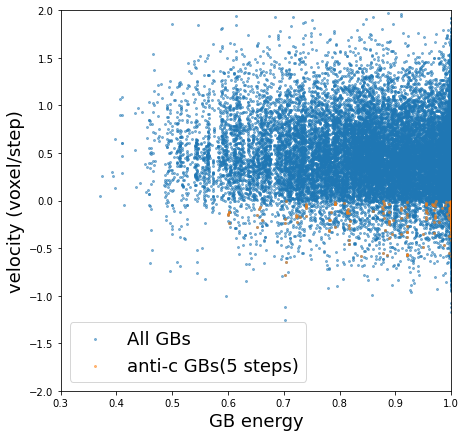

<Figure size 432x288 with 0 Axes>

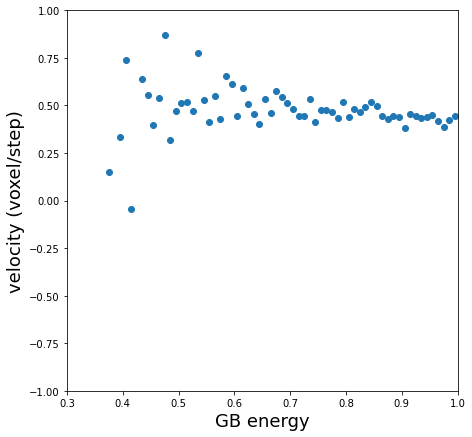

<Figure size 432x288 with 0 Axes>

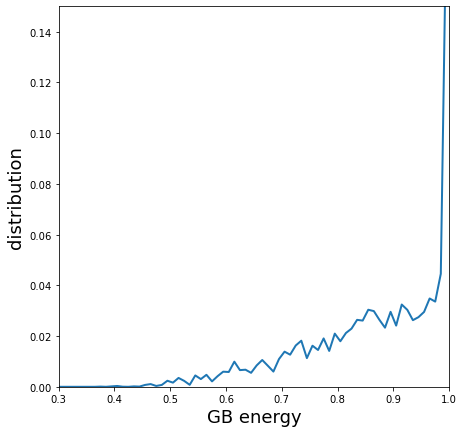

<Figure size 432x288 with 0 Axes>

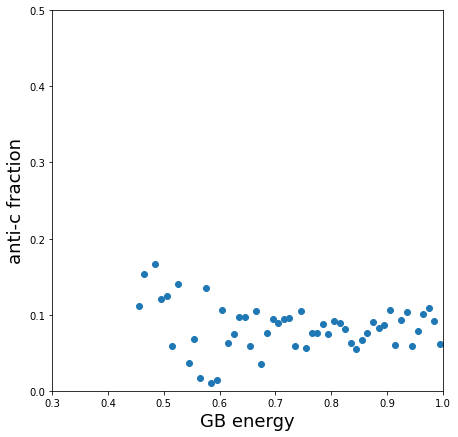

<Figure size 432x288 with 0 Axes>

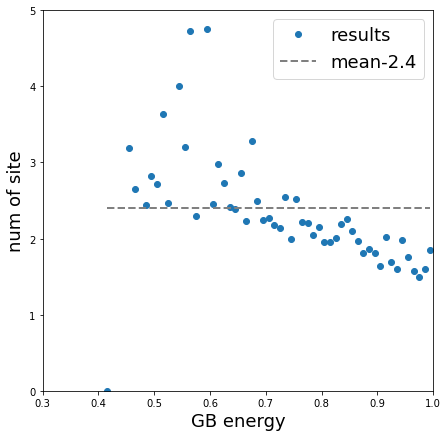

In [11]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_exrandom_remove_0step, velocity_1Dlist_exrandom_remove_0step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-2,2])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_exrandom_remove_0step)):
        if abs(GBenergy_1Dlist_exrandom_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
        if velocity_1Dlist_exrandom_remove_0step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_exrandom_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


 27%|██▋       | 14/51 [00:05<00:15,  2.34it/s]


<Figure size 432x288 with 0 Axes>

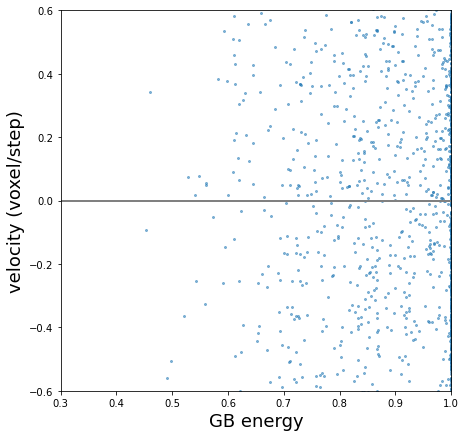

<Figure size 432x288 with 0 Axes>

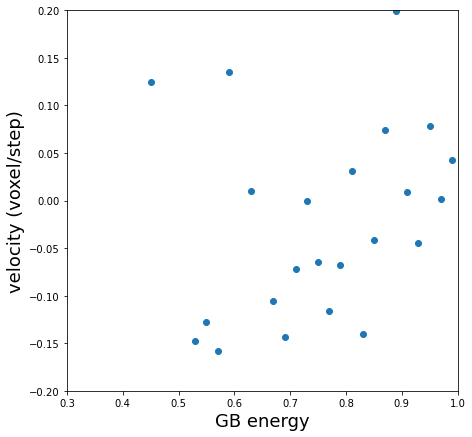

<Figure size 432x288 with 0 Axes>

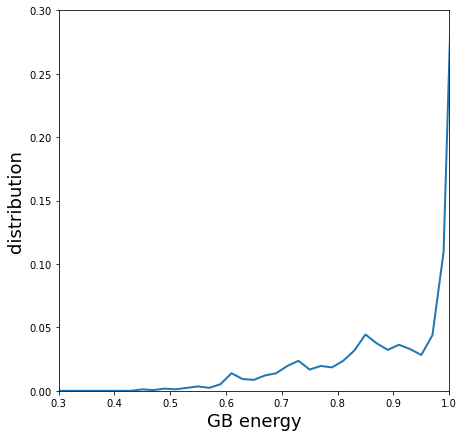

<Figure size 432x288 with 0 Axes>

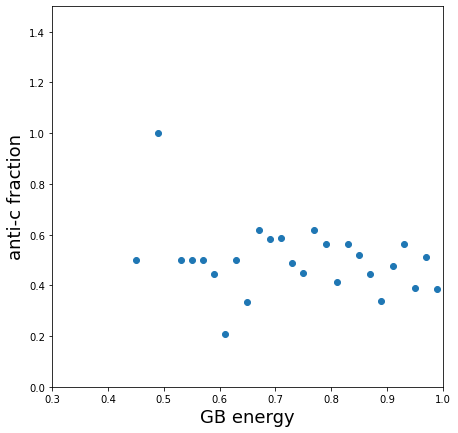

In [13]:
    # For one specific time steps with 1000 grains

    # get expected time step
    expected_grain_num = 2000
    grain_num_array = np.zeros(npy_file_aniso.shape[0])
    # Calculate the number of grains
    for i in tqdm(range(npy_file_aniso.shape[0])):
        grain_num = len(np.unique(npy_file_aniso[i,:]))
        grain_num_array[i] = grain_num
        if grain_num < expected_grain_num/2: break
    expected_time_step = int(np.argmin(abs(grain_num_array - expected_grain_num)))

    # get all data on specific grain step
    expected_step_curvature_list = GB_list_curvature_list[expected_time_step]
    expected_step_velocity_list = GB_list_velocity_list[expected_time_step]
    expected_step_GBenergy_list = GB_list_GBenergy_list[expected_time_step]
    expected_step_curvature_list_exrandom = GB_list_curvature_list_exrandom[expected_time_step]
    expected_step_velocity_list_exrandom = GB_list_velocity_list_exrandom[expected_time_step]
    expected_step_GBenergy_list_exrandom = GB_list_GBenergy_list_exrandom[expected_time_step]

    # plot
    figure_name_all = f"figures/2D_velocity_GBenergy_{case_name}_5d_grain{expected_grain_num}.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(expected_step_GBenergy_list_exrandom, expected_step_velocity_list_exrandom,s=4,alpha=0.5,label='All GBs')
    # GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    # GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    # GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    # plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.plot([0.3,1.0],[0,0],'-',color='grey',linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.6,0.6])
    # plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.02
    x_lim = [0.20,1.2]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    
    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(expected_step_GBenergy_list_exrandom)):
        if abs(expected_step_GBenergy_list_exrandom[index])>=1.01: continue
        GBenergy_bin[int((expected_step_GBenergy_list_exrandom[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((expected_step_GBenergy_list_exrandom[index]-x_lim[0])//bin_interval)] += expected_step_velocity_list_exrandom[index]
        if expected_step_velocity_list_exrandom[index] < 0: antic_num_bin[int((expected_step_GBenergy_list_exrandom[index]-x_lim[0])//bin_interval)] += 1
        if int((expected_step_GBenergy_list_exrandom[index]-x_lim[0])//bin_interval)<0: print(expected_step_GBenergy_list_exrandom[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_{case_name}_5d_afterBin_grain{expected_grain_num}.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.2,0.2])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.3])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)

    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,1.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)

    anti_c_data_file_name = f"data/2D_antic_data_{case_name}_grain{expected_grain_num}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)



In [ ]:
    # Plot relationship for each time steps
    for time_step in range(0,len(GB_list_velocity_list),10):
        figure_name = f"figures/3D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(GB_list_curvature_list[time_step], GB_list_velocity_list[time_step],s=4,alpha=0.5)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-10,10])
        # plt.savefig(figure_name, dpi=400,bbox_inches='tight')
        
        # plot velocity VS averaged curvature
        bin_interval = 0.001
        x_lim = [0.0,0.1]
        bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
        curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        for index in range(len(GB_list_curvature_list[time_step])):
            if abs(GB_list_curvature_list[time_step][index])>x_lim[1]: continue
            curvature_bin[int((GB_list_curvature_list[time_step][index]-x_lim[0])//bin_interval)] += 1
            velocity_bin[int((GB_list_curvature_list[time_step][index]-x_lim[0])//bin_interval)] += GB_list_velocity_list[time_step][index]
        for i in range(bin_number): 
            if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
        # plot
        figure_name_all_bin = f"figures/3D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
        plt.plot(curvature_coordinate, velocity_bin,'o', linewidth=2)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-5,5])
        # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')